# Week 5 Mini Project

**The Data Challenge Source:** https://www.kaggle.com/competitions/gan-getting-started/   
**My Github Link:** https://github.com/lzheng01/GAN-Monet-Painting

________
# 1. Introduction
_____

This project is part of the Monet Style Image Generation competition on Kaggle, where the challenge is to build a Generative Adversarial Network (GAN) capable of creating 7,000 to 10,000 images in the distinctive style of Claude Monet. The goal is to generate images that are indistinguishable from real Monet paintings, evaluated using the Memerization-informed Fréchet Inception Distance (MiFID).

The dataset includes authentic Monet paintings, and participants can also explore additional datasets featuring works from artists like Cezanne, Ukiyo-e, and Van Gogh. The generated images must be in 256x256x3 (RGB) format, and the final submission should be a single zip file named images.zip.

## 1.1 Libraries Installation and Directory Setup

In [1]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import sys
import cv2
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import defaultdict

In [2]:
# Setup my google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set seed for reproducibility
def seed_everything(seed=888):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [4]:
root_path = "/content/drive/My Drive/GAN/gan-getting-started"
os.listdir(root_path)

['.DS_Store', 'monet_tfrec', 'photo_jpg', 'monet_jpg', 'photo_tfrec']

In [5]:
# Reading img in rgb
read_img = lambda path: cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [6]:
# Show the number of images in the Monet and Photo folder
print('Number of images in Monet folder: ', len(os.listdir(f'{root_path}/monet_jpg/')))
print('Number of images in photo folder: ', len(os.listdir(f'{root_path}/photo_jpg/')))

Number of images in Monet folder:  300
Number of images in photo folder:  7038


## 1.2 Exploratory Analysis (EDA)

In [7]:
# Load the sample image of monet and photo
data_path = f"{root_path}/photo_jpg"
sample_photo_path = os.path.join(data_path, os.listdir(data_path)[20])
print(sample_photo_path)
sample_photo = read_img(sample_photo_path)

data_path = f"{root_path}/monet_jpg"
sample_monet_path = os.path.join(data_path, os.listdir(data_path)[20])
sample_monet = read_img(sample_monet_path)

/content/drive/My Drive/GAN/gan-getting-started/photo_jpg/ed9f0b8b5d.jpg


In [8]:
sample_photo.shape

(256, 256, 3)

In [9]:
sample_photo.min(), sample_photo.max(), sample_photo.dtype

(0, 255, dtype('uint8'))

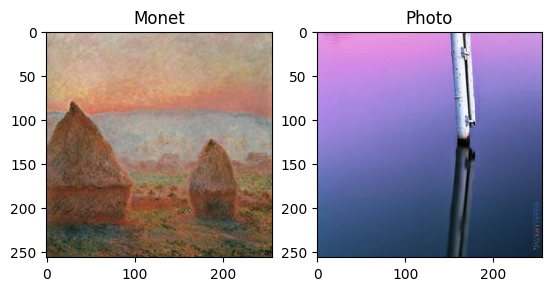

In [13]:
# Photo
plt.subplot(122)
plt.title("Photo")
plt.imshow(sample_photo)

# Monet
plt.subplot(121)
plt.title("Monet")
plt.imshow(sample_monet)

Both the photo and the Monet paiting have same 256 * 256 dimension, so we can use monet to train the GAN.

In [14]:
# Conduct the function to display some sample images
def display_sample_images_chanels(file_path, num_samples=1, title=""):
    fig, ax = plt.subplots(2*num_samples, 4, figsize=(20, 4*2*num_samples))
    sample_image_path = file_path
    image_decoded = cv2.imread(sample_image_path)
    image_decoded = cv2.cvtColor(image_decoded, cv2.COLOR_BGR2RGB )
    # Original image
    ax[0][0].imshow(image_decoded)
    ax[0][0].axis('off')
    ax[0][0].set_title(f'{title}',color='#8d4908')

    for j in range(3):
        image_inChanel = image_decoded[:,:,j].reshape(-1)
        ax[0][j+1].hist(image_inChanel,bins=25, color=['#ad2004', '#007446', '#13358f'][j], alpha=0.3)
        ax[0][j+1].set_title(f'{title}',color='#8d4908')

    # Gray scale image
    ax[1][0].imshow(np.mean(image_decoded, axis=2),cmap="gray")
    ax[1][0].set_title(f'{title}', color='#8d4908')

    # Red, Green, and Blue Chanels Image
    for k in range(3):
        image_individual_Chanel= np.full_like(image_decoded, 0)
        image_individual_Chanel[:, :, k] = image_decoded[:, :, k]
        ax[1][k+1].imshow(image_individual_Chanel)
        ax[1][k+1].set_title(f'{title}', color='#8d4908')

    plt.show()

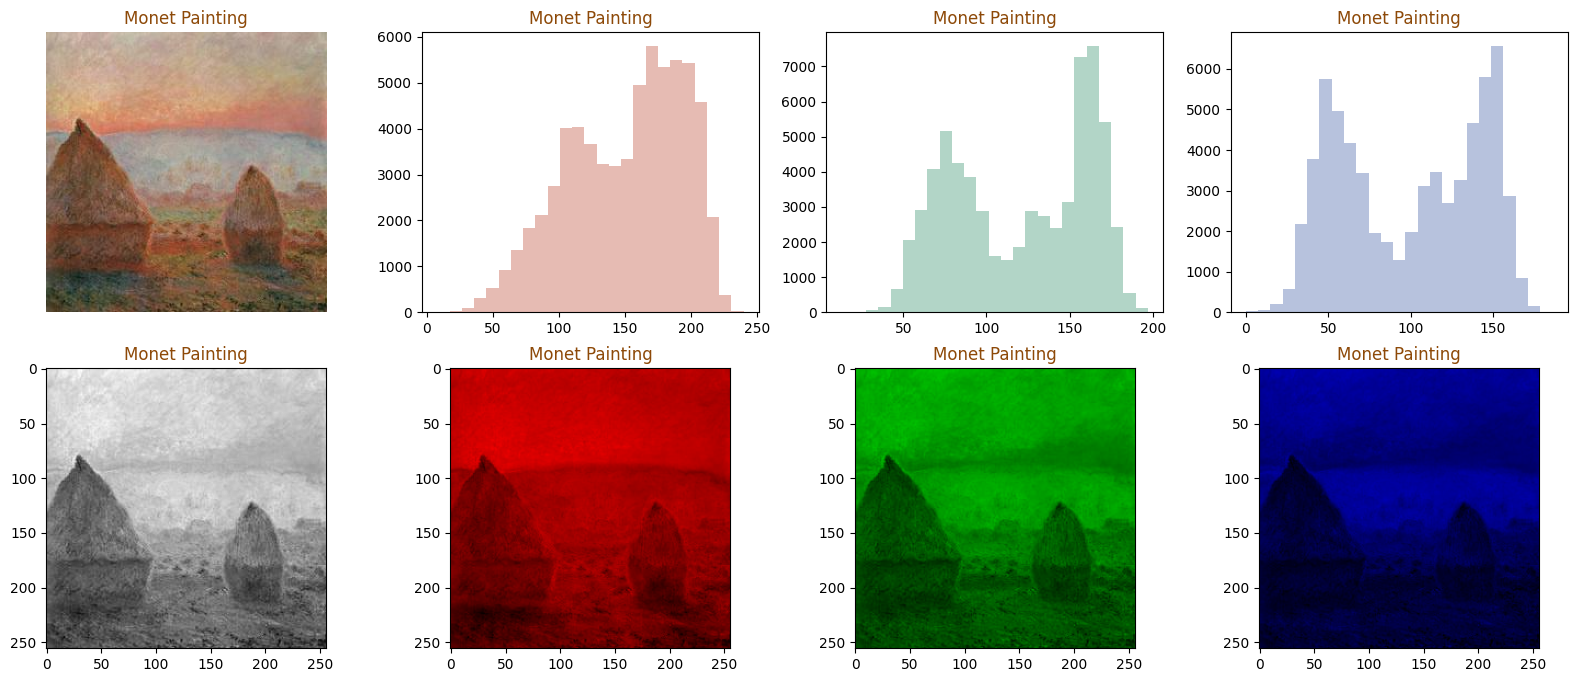

In [15]:
display_sample_images_chanels(sample_monet_path, title="Monet Painting")

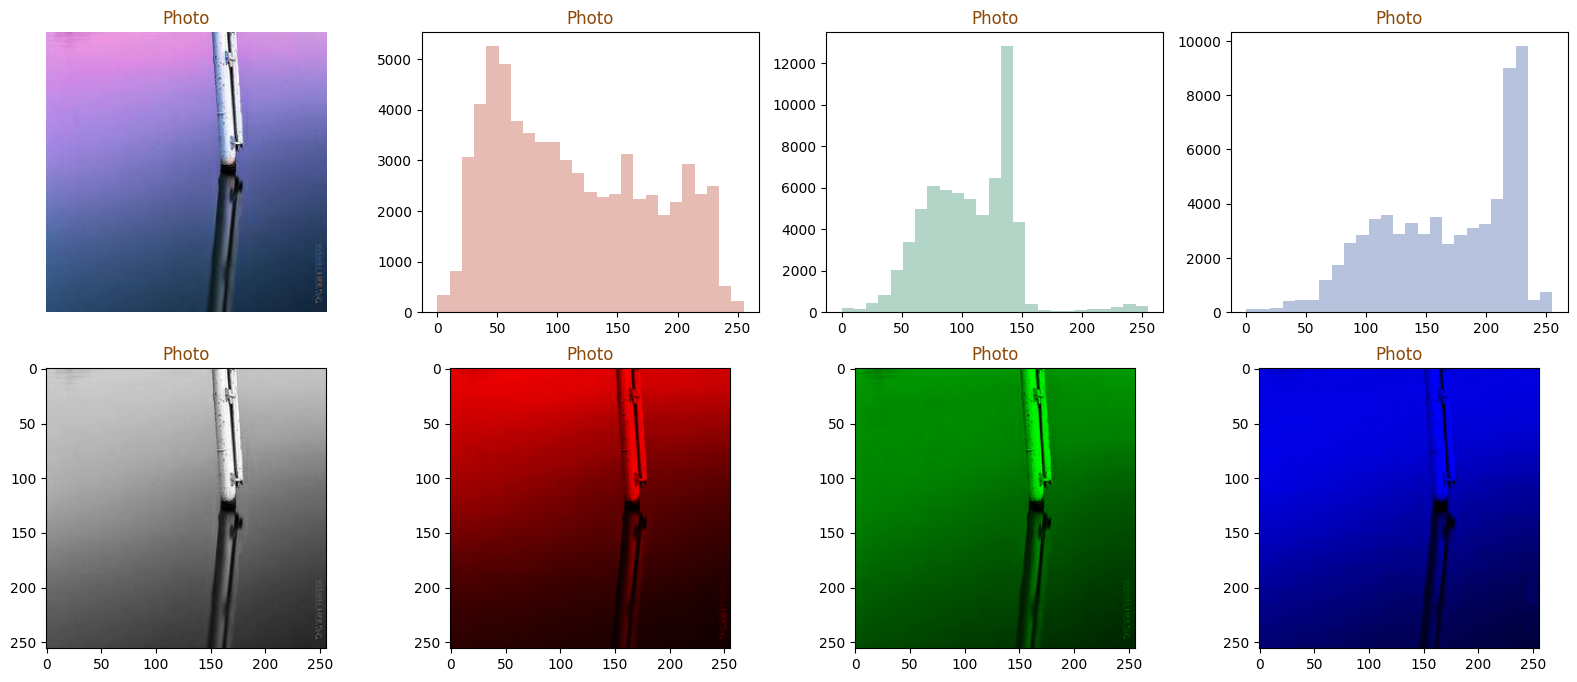

In [16]:
display_sample_images_chanels(sample_photo_path, title="Photo")

When breaking down the images into different channels, there is no distinct trends to differentiate the Monet paintings with actual photos.

-------
# 2. Model Architecture
-------

## 2.1 CycleGAN
CycleGAN is a technique for unsupervised image-to-image translation that maps images from one domain to another without requiring paired examples. It uses two sets of GANs to ensure that an image translated from domain A to domain B can be translated back to domain A, preserving the original image characteristics. This CycleGAN model is based on the 2017 paper “Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks” by Jun-Yan Zhu et al. The project implements some of the code from this repository.
https://github.com/ADulian/CycleGAN/tree/main

In [17]:
# img params
IMG_H, IMG_W, IMG_C = sample_photo.shape
print(f"IMG_H: {IMG_H}, IMG_W: {IMG_W}, IMG_C: {IMG_C}")

IMG_H: 256, IMG_W: 256, IMG_C: 3


## 2.2 Basic Blocks

Implements 2 basic blocks
- A Downsample block that aims to downsample input by 2
    - Input -> Conv2D -> (OPT) GroupNorm (InstanceNorm) -> LeakyReLU
- An Upsample block that aims to upsample input by 2
    - Input -> ConvTranspose2d -> GroupNorm (InstanceNorm) -> (OPT) Dropout -> ReLU

In [18]:
# --------------------------------------------------------------------------------
class Downsample(nn.Module):
    """ A simple convolutional block that downsamples feature maps by 2 (stride=2)

    For example
        input_tensor [256, 256] -> output_tensor [128, 128]

    Padding = same
    Bias = False (although this will be checked)

    Model
        Conv2d -> (opt) InstanceNorm2d -> LeakyReLU

    """

    # --------------------------------------------------------------------------------
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 norm=True):

        """ Init downsample module

        ---
        Parameters
            in_channels: Number of input channels
            out_channels: Number of output channels
            kernel_size: Kernel size
            norm: Whether to apply normalisation layer
        """

        super().__init__()

        # --- Layers
        # Convolution Layer
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=2,  # Downsample by 2
                              padding=(kernel_size - 1) // 2,  # Same padding
                              bias=False)  # ToDo: Check if this should be conditioned on norm

        # Normalisation layer (equivalent of GroupNorm where num_groups=out_channels
        if norm:
            self.norm = nn.InstanceNorm2d(num_features=out_channels)
        else:
            self.norm = None

        # Activation layer
        self.act = nn.LeakyReLU()

    # --------------------------------------------------------------------------------
    def forward(self,
                x):

        """ Downsample input tensor

        ---
        Parameters
            x: Input tensor

        ---
        Returns
            out: x downsampled by 2

        """

        out = self.conv(x)

        if self.norm:
            out = self.norm(out)

        out = self.act(out)

        return out


In [19]:
# --------------------------------------------------------------------------------
class Upsample(nn.Module):
    """ A simple convolutional block that upsamples feature maps by 2 (kernel_size=4, stride=2)

        For example
            input_tensor [128, 128] -> output_tensor [256, 256]

        Padding = same
        Bias = False
        Dropout = 0.5

        Model
            Conv2d -> InstanceNorm2d -> (opt) Dropout -> ReLU

        """

    # --------------------------------------------------------------------------------
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=4,
                 dropout=True):
        """ Init upsample module

        ---
        Parameters
            in_channels: Number of input channels
            out_channels: Number of output channels
            kernel_size: Kernel size
            dropout: Whether to apply dropout
        """

        super().__init__()

        # --- Layers
        # Transpose Convolution Layer
        self.conv = nn.ConvTranspose2d(in_channels=in_channels,
                                       out_channels=out_channels,
                                       kernel_size=kernel_size,
                                       stride=2,  # Upsample by 2
                                       padding=(kernel_size - 1) // 2,  # Same padding
                                       bias=False)

        # Normalisation layer (equivalent of GroupNorm where num_groups=out_channels
        self.norm = nn.InstanceNorm2d(num_features=out_channels)

        # Dropout
        if dropout:
            self.dropout = nn.Dropout(0.5)
        else:
            self.dropout = None

        # Activation layer
        self.act = nn.ReLU()

    # --------------------------------------------------------------------------------
    def forward(self,
                x):
        """ Upsample input tensor

        ---
        Parameters
            x: Input tensor

        ---
        Returns
            out: x upsampled by 2

        """

        out = self.conv(x)
        out = self.norm(out)

        if self.dropout:
            out = self.dropout(out)

        out = self.act(out)

        return out

## 2.3 Generator

In [20]:
def conv_weight_init(m):
    """ Initialise Conv2D and ConvTranspose2D with N(0, 0.02)
    """
    if any(isinstance(m, _m) for _m in [nn.Conv2d, nn.ConvTranspose2d]):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

A simple Generator network made out of an Encoder and Decoder with skip connections just like in U-Net (I believe)
- Encoder
    - 7 Downsample blocks that take input image and produce an output of shape [512, IMG_H//128, IMG_W//128]
- Decoder
    - 6 Upsample blocks that the latent features and produce an output of shape [64, LATENT_H * 64, LATENT_W * 64]
- Final layer
    - A final ConvTranspose2D layer that takes the output of Decoder and upsamples it once again so that the final output is of shape [3, IMG_H, IMG_W]

In [21]:
# --------------------------------------------------------------------------------
class Generator(nn.Module):
    """ A Generator Network

    ---
    Structure
        Img -> Encoder -> Decoder -> Img_Pred

        Encoder
            7 x Downsample blocks
            Output -> Latent Tensor [512, IMG_H / 128, IMG_W / 128]
        Decoder
            6 x Upsample blocks
            Output -> Upsampled Latent Tensor [64, IMG_H / 2, IMG_W / 2]
        Final Upsample
            ConvTranspose2D -> TanH
            Output -> Target Image [IMG_C, IMG_H, IMG_W]

    """

    # --------------------------------------------------------------------------------
    def __init__(self):
        """ Init CycleGAN's Generator

        """
        super().__init__()

        # --- Encoder and Decoder
        self.encoder = self._init_encoder()
        self.decoder = self._init_decoder()

        # Final Upsample
        self.out = nn.ConvTranspose2d(in_channels=128,
                                      out_channels=3,
                                      kernel_size=4,
                                      stride=2, padding=1)

        # Maybe softsign could be better than TanH
        self.act = nn.Tanh()

        # Initialise conv wights with N(0, 0.02)
        self.apply(conv_weight_init)

    # --------------------------------------------------------------------------------
    def forward(self,
                x):
        """ Generate x_hat

        ---
        Parameters
            x: Input tensor (img)

        ---
        Returns
            torch.Tensor: Output tensor (img pred)

        """

        # Encode to latent space / 128 #512
        skips = []  # Skip connections U-Net Style
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)

        # Skip last one, bottom bit, latent space
        skips = reversed(skips[:-1])

        # Decode form latent space *64 #128
        for layer, skip in zip(self.decoder, skips):
            x = layer(x)
            x = torch.cat((x, skip), dim=1)

        # Upsample so that out.shape == x.shape
        out = self.act(self.out(x))

        return out

    # --------------------------------------------------------------------------------
    def _init_encoder(self):
        """ A Sequential Encoder with 7 Downsample Blocks each downsampling by 2

        ---
        Returns
            nn.Sequential: Encoder

        """

        # Settings
        kernel_size = 4
        in_channels = 64

        # Final layer will have 512 feature maps and it's final output size is x / 128
        out_channels = [128, 256, 512, 512, 512, 512]

        # First layer doesn't use norm so just add it now
        encoder = [Downsample(in_channels=3, out_channels=in_channels,
                              kernel_size=kernel_size, norm=False)]

        for out_ch in out_channels:
            # Add layer
            encoder.append(Downsample(in_channels=in_channels, out_channels=out_ch,
                                      kernel_size=kernel_size))

            # Update in_channels
            in_channels = out_ch

        return nn.Sequential(*encoder)

    # --------------------------------------------------------------------------------
    def _init_decoder(self):
        """ A Sequential Decoder with 6 Upsample Blocks each upscaling by 2

        ---
        Returns
            nn.Sequential: Decoder

        """

        # Settings
        kernel_size = 4
        in_channels = [512, 1024, 1024, 1024, 512, 256]

        # Final layer will have the same number of channels as the output of first downsample from encoder
        out_channels = [512, 512, 512, 256, 128, 64]
        dropout = [True, True, True, False, False, False]

        decoder = [Upsample(in_channels=in_ch, out_channels=out_ch,
                            kernel_size=kernel_size, dropout=drop)

                   for in_ch, out_ch, drop in zip(in_channels, out_channels, dropout)]

        return nn.Sequential(*decoder)

## 2.4 Discriminator

In [22]:
# --------------------------------------------------------------------------------
class DiscriminatorHistory:
    """ Keep a history of fake samples that Discriminator can use to improve its robustness
    """

    # --------------------------------------------------------------------------------
    def __init__(self,
                 buffer_size=50):
        """ Init History module

        ---
        Parameters
            buffer_size: Size of the buffer, as per paper the defualt is 50

        The paper says "We keep an image buffer that stores the 50 previously created images",
        however, what's worth noting is that the authors used a batch size of 1 for training,
        meaning that the network did 50 updates before sampling from history. Worth rethinking
        whether the buffer_size should be dependant on the batch_size

        """

        self.buffer_size = buffer_size

        # Empty Tensor
        self.buffer = torch.Tensor()


    # --------------------------------------------------------------------------------
    def __call__(self,
                 x):
        """ Forward

        Sample randomly from history buffer and add new sampels

        ---
        Parameters
            x: Input Tensor

        ---
        Returns
            Tensor with mixed samples from input and history

        """

        # Make sure that the buffer is on the same device as x
        if self.buffer.device != x.device:
            self.buffer = self.buffer.to(x.device)

        # Check if buffer is filled
        if len(self.buffer) >= self.buffer_size:
            # Sample from the buffer
            sample_size = max(len(x) // 2, 1)
            history_indices = list(range(0, self.buffer_size))
            history_get_indices = random.sample(history_indices, k=sample_size)
            x1 = self.buffer[history_get_indices]

            if sample_size == 1:
                return x1

            # Sample from the input
            x_indices = list(range(0, len(x)))
            x_get_indices = random.sample(x_indices, k=sample_size)
            x_set_indices = list(set(x_indices) - set(x_get_indices))
            x2 = x[x_get_indices]

            # Replace buffer with other set of samples
            self.buffer[history_get_indices] = x[x_set_indices]

            # Concat
            x = torch.cat((x1, x2), 0)

        # Fill the buffer
        else:
            self.buffer = torch.cat((self.buffer, x), 0)

        # Return
        return x


In [23]:
# --------------------------------------------------------------------------------
class Discriminator(nn.Module):
    """ A Discriminator Network

    ---
    Structure
        Img -> Discriminator -> Grid of predictions

    """

    # --------------------------------------------------------------------------------
    def __init__(self):
        """ Init CycleGAN's Discriminator

        """

        super().__init__()

        # --- Default settings
        base_channels = 64
        kernel_size = 4

        # --- History
        self.history = DiscriminatorHistory()

        # --- Discriminator network
        self.discriminator = nn.Sequential(
            Downsample(in_channels=3, out_channels=base_channels,
                       kernel_size=kernel_size, norm=False),
            Downsample(in_channels=base_channels, out_channels=base_channels * 2,
                       kernel_size=kernel_size),
            Downsample(in_channels=base_channels * 2, out_channels=base_channels * 4,
                       kernel_size=kernel_size),
            nn.ZeroPad2d(padding=(0, 2, 0, 2)),
            nn.Conv2d(in_channels=base_channels * 4, out_channels=base_channels * 8,
                      kernel_size=4, stride=1, bias=False),
            nn.InstanceNorm2d(num_features=base_channels * 8),
            nn.ZeroPad2d(padding=(0, 2, 0, 2)),
            nn.Conv2d(in_channels=base_channels * 8, out_channels=1,
                      kernel_size=4, stride=1),
            #             nn.Sigmoid()
        )

        # Initialise conv wights with N(0, 0.02)
        self.apply(conv_weight_init)

    # --------------------------------------------------------------------------------
    def forward(self,
                x,
                sample_history=False):
        """ Discriminate between real/fake img

        ---
        Parameters
            x: Input tensor (img)
            sample_history: If true it will mix x with samples from buffer

        ---
        Returns
            torch.Tensor: Output tensor (pred grid)

        """

        # Update x based on history
        if sample_history:
            x = self.history(x)


        return self.discriminator(x)

## 2.5 Testing the images

In [24]:
# To Torch Tensor
torch_sample = torch.tensor(sample_photo, dtype=torch.float32)

# -1 to 1
torch_sample = (torch_sample / 255.0 - 0.5) / 0.5

# H,W,C to C,H,W
torch_sample = torch_sample.permute(2,0,1)

# Add Batch Dim 1,C,H,W
torch_sample = torch_sample.unsqueeze(dim=0)

In [25]:
monet_generator = Generator()

In [26]:
with torch.inference_mode():
    monet_generator.eval()
    to_monet = monet_generator(torch_sample).detach()
    to_monet.shape

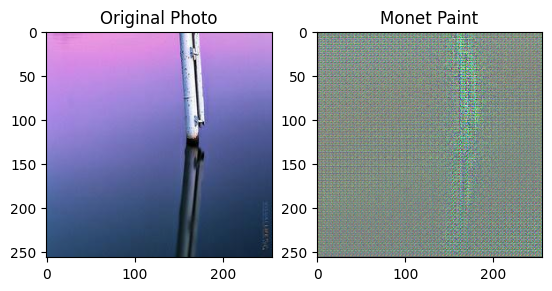

In [27]:
plt.subplot(1,2,1)
plt.title("Original Photo")
plt.imshow(torch_sample[0].permute(1,2,0) * 0.5 + 0.5)

plt.subplot(1,2,2)
plt.title("Monet Paint")
plt.imshow(to_monet[0].permute(1,2,0) * 0.5 + 0.5)

## 2.6 CycleGAN

CycleGAN is built of 4 neural nets

- 2 Generators
    - Monet Generator - To go from Photo to Monet (G)
    - Photo Generator - To got from Monet to Photo (F)
- 2 Discriminators
    - Monet Discriminator - To say whether input is a real/fake monet (Dy)
    - Photo Discriminator - To say whether input is a real/fake photo (Dx)

In [28]:
# Define CycleGAN
# --------------------------------------------------------------------------------
class CycleGAN(nn.Module):

    # --------------------------------------------------------------------------------
    def __init__(self,
                 lr=2e-4,
                 lambda_cycle=10):  # Not sure what that is yet
        """ Cycle GAN model

        ---
        Structure:
            - 2 Generators
                - Monet Generator - To go from Photo to Monet (G)
                - Photo Generator - To got from Monet to Photo (F)

            - 2 Discriminators
                - Monet Discriminator - To say whether input is a real/fake monet (Dy)
                - Photo Discriminator - To say whether input is a real/fake photo (Dx)


        """
        super().__init__()

        # Define Generators and Discriminators
        self.gen_monet = Generator()
        self.optim_gen_monet = optim.Adam(self.gen_monet.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))
        self.gen_photo = Generator()
        self.optim_gen_photo = optim.Adam(self.gen_photo.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))

        self.disc_monet = Discriminator()
        self.optim_disc_monet = optim.Adam(self.disc_monet.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))
        self.disc_photo = Discriminator()
        self.optim_disc_photo = optim.Adam(self.disc_photo.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))

        # Loss functions
        self.loss_l2 = nn.MSELoss()
        self.loss_l1 = nn.L1Loss()

        # Attribs
        self.lambda_cycle = lambda_cycle

    # --------------------------------------------------------------------------------
    def forward(self, x):
        """ Main point of the model is to go from photo -> monet so forward does just that

        Expects a single tensor (photo data)
            x: [btach, 3, 256, 256] - Real photo
        """

        return self.gen_monet(x)

    # --------------------------------------------------------------------------------
    def forward_apply_style(self,
                            real_A,
                            style="monet"):
        """ Apply one of the styles either monet or photo

        In addition the function returns more than just styled photo e.g.
        Disciminators on Fake, Real and Cycled Photo

        ---
        Parameters
            real_A: A batch of real samples from domain A being transfered to domain B
            style: Domain B, Applies either monet or photo style

        ---
        Returns
            dict: Dictionary of outputs from model

        """

        with torch.inference_mode(mode=True):
            self.eval()

            # Set networks and Domain
            if style == "monet":
                gen_A = self.gen_photo
                gen_B = self.gen_monet

                disc_A = self.disc_photo
                disc_B = self.disc_monet
            elif style == "photo":
                gen_A = self.gen_photo
                gen_B = self.gen_monet

                disc_A = self.disc_photo
                disc_B = self.disc_monet
            else:
                raise ValueError(f"Style can be either monet or photo, given: {style}")

            # ---
            # Forward, notation uses P=Photo and M=Monet to easier demonstrate the flow
            # x_P -> G_M -> \hat{x}_M
            fake_B = gen_B(real_A)

            # \hat{x}_M -> G_P -> \hat{x}_P
            cycled_A = gen_A(fake_B)

            # \hat{x}_M -> D_M -> \hat{y}_M
            disc_fake_B = disc_B(fake_B)

            # x_P -> D_P -> y_P
            disc_real_A = disc_A(real_A)

            # \hat{x}_P -> D_M -> \hat{y}_P
            disc_cycled_A = disc_A(cycled_A)

        return {"real_A" : real_A,
                "gen_fake_B" : fake_B,
                "gen_cycled_A" : cycled_A,
                "disc_fake_B" : disc_fake_B,
                "disc_real_A" : disc_real_A,
                "disc_cycled_A" : disc_cycled_A}

    # --------------------------------------------------------------------------------
    def forward_step(self, x):
        """ A single forward step for the model

        Forward -> Loss -> Backward -> Optimise

        Expects a tuple of 2 tensors
            (tensor, tensor): [batch, 3, 256, 256] - Real monet and photo
        """

        # Unpack data
        x_monet, x_photo = x

        # Zero Grad Optimisers
        self.optim_zero_grad()

        # --- Generate fake data
        x_fake_monet = self.gen_monet(x_photo)  # Real Photo -> Gm -> Fake Monet
        x_fake_photo = self.gen_photo(x_monet)  # Real Monet -> Gp -> Fake Photo

        # --- Discriminators
        # Monet
        d_real_monet = self.disc_monet(x_monet)  # How real does this real monet seems
        d_fake_monet = self.disc_monet(x_fake_monet.detach(), sample_history=True)  # How fake does this fake seems

        # Photo
        d_real_photo = self.disc_photo(x_photo)
        d_fake_photo = self.disc_photo(x_fake_photo.detach(), sample_history=True)

        # Discriminators Loss
        d_loss_monet = self.disc_loss(x_real=d_real_monet,
                                      x_fake=d_fake_monet)

        d_loss_photo = self.disc_loss(x_real=d_real_photo,
                                      x_fake=d_fake_photo)

        d_loss = d_loss_monet + d_loss_photo

        # Backward
        d_loss.backward()

        # Optimise
        self.optim_disc_monet.step()
        self.optim_disc_photo.step()

        # --- Generators
        # Adversarial
        x_adv_monet = self.disc_monet(x_fake_monet)  # How real does this fake monet seems
        x_adv_photo = self.disc_photo(x_fake_photo)

        # Cycle
        x_cycled_monet = self.gen_monet(x_fake_photo)  # Fake Photo -> Gm -> Cycled Monet
        x_cycled_photo = self.gen_photo(x_fake_monet)  # Fake Monet -> Gp -> Cycled Photo

        # Adversarial Loss
        g_loss_adv_monet = self.loss_l2(torch.ones_like(x_adv_monet), x_adv_monet)
        g_loss_adv_photo = self.loss_l2(torch.ones_like(x_adv_photo), x_adv_photo)

        # Cycle Loss
        g_loss_cycle_monet = self.loss_l1(x_monet, x_cycled_monet) * self.lambda_cycle
        g_loss_cycle_photo = self.loss_l1(x_photo, x_cycled_photo) * self.lambda_cycle

        # Identity Loss
#         g_loss_idt_monet = self.loss_l1(x_monet, x_fake_monet) * self.lambda_cycle
#         g_loss_idt_photo = self.loss_l1(x_photo, x_fake_photo) * self.lambda_cycle

        # Total Loss
        g_loss_monet = g_loss_adv_monet + g_loss_cycle_monet #+ g_loss_idt_monet
        g_loss_photo = g_loss_adv_photo + g_loss_cycle_photo #+ g_loss_idt_photo
        g_loss = g_loss_monet + g_loss_photo

        # Backward
        g_loss.backward()

        # Optimise
        self.optim_gen_monet.step()
        self.optim_gen_photo.step()

        # Get Losses
        return {
            "g_monet" : g_loss_monet,
            "g_photo" : g_loss_photo,
            "d_monet" : d_loss_monet,
            "d_photo" : d_loss_photo
        }

    # --------------------------------------------------------------------------------
    def disc_loss(self,
                  x_real,
                  x_fake):
        """ Compute loss for discriminator

        Loss = 1/2(Real loss + Fake loss)

        Expects 2 tensor
            x_real: [batch, 3, 256, 256] - A real photo
            x_fake: [batch, 3, 256, 256] - A fake photo from generator

        """

        loss_real = self.loss_l2(torch.ones_like(x_real), x_real)
        loss_fake = self.loss_l2(torch.zeros_like(x_fake), x_fake)

        return (loss_real + loss_fake) * 0.5

    # --------------------------------------------------------------------------------
    def optim_zero_grad(self):
        """ Apply zero grad on all optimisers
        """

        # Generators
        self.optim_gen_monet.zero_grad()
        self.optim_gen_photo.zero_grad()

        # Discriminators
        self.optim_disc_monet.zero_grad()
        self.optim_disc_photo.zero_grad()

## 2.7 Datasetloader

In [29]:
class MonetDataset(Dataset):
    def __init__(self,
                 root_path):

        # Paths
        self.root_path = root_path
        self.photo_paths = os.listdir(f"{root_path}/photo_jpg")
        self.monet_paths = os.listdir(f"{root_path}/monet_jpg")

    def __len__(self):
        return len(self.photo_paths)

    def __getitem__(self, idx):
        """ Get one of the photos and a random monet
        """

        # Get a photo path
        path_photo = f"{root_path}/photo_jpg/{self.photo_paths[idx]}"

        # Get a random monet path
        path_monet = f"{root_path}/monet_jpg/{random.choices(self.monet_paths, k=1)[0]}"

        # Load imgs and transform
        x_photo = self.to_tensor(self.read_img(path_photo))
        x_monet = self.to_tensor(self.read_img(path_monet))

        return x_monet, x_photo, path_photo

    def to_tensor(self, x):
        """ Transform uint8 image [0,255] to torch float32 [-1,1]
        """
        return torch.tensor(x, dtype=torch.float32).permute(2,0,1) / 127.5 - 1.0

    def read_img(self, path):
        """ Read img with cv2 and transform to RGB
        """
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

## 2.8 Train the Model

In [30]:
# Training params
NUM_EPOCHS = 10
BATCH_SIZE = 32


# Device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Keep losses per epoch
loss_epoch = defaultdict(list)

# Dataset and data loader
dataset = MonetDataset(root_path=root_path)
data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)

# Model
cycle_gan = CycleGAN(lr=2e-4,).to(device)

In [31]:
# Train for N epochs
for i in range(1, NUM_EPOCHS + 1):

    # Tqdm
    with tqdm(total=len(data_loader),
          desc=f"Epoch {i}/{NUM_EPOCHS}",
          ascii=True,
          colour="green") as pbar:

        # Per batch
        loss_batch = defaultdict(list)
        for x in data_loader:
            x_monet = x[0].to(device)
            x_photo = x[1].to(device)

            # Batch of data
            loss = cycle_gan.forward_step((x_monet, x_photo))

            # Update dict
            for k, v in loss.items():
                loss_batch[k].append(v.item())

            # Bar Update
            pbar.set_postfix({k:v.item() for k, v in loss.items()})
            pbar.update()

        # Update mean loss for epoch
        for k, v in loss_batch.items():
            loss_epoch[k].append(np.mean(v))

Epoch 10/10: 100%|##########| 220/220 [11:45<00:00,  3.20s/it, g_monet=1.17, g_photo=1.19, d_monet=0.25, d_photo=0.29]


## 2.9 Export Images

In [32]:
import PIL
! mkdir images

In [33]:
i = 1
data_loader = DataLoader(dataset=dataset, batch_size=1)
with torch.inference_mode(mode=True):
    cycle_gan.eval()

    for x in data_loader:
        photo, _, path = x

        pred = cycle_gan(photo.to(device)).cpu().squeeze().numpy()
        pred = np.transpose(pred, (1,2,0))

        pred = (pred * 127.5 + 127.5).astype(np.uint8)
        path = path[0].split("/")[-1]
        pred_img = PIL.Image.fromarray(pred)
        pred_img.save(f'images/{path}')

        i += 1

______
# 3. Results and Analysis
______



## 3.1 Visualization of loss

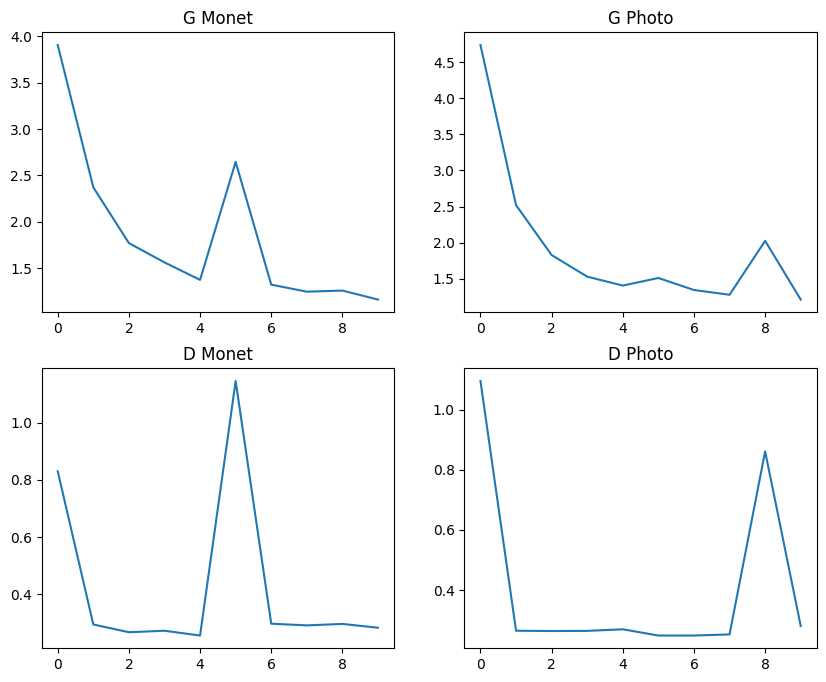

In [34]:
plt.figure(figsize=(10,8))

# Generators
plt.subplot(221)
plt.plot(range(len(loss_epoch["g_monet"])), loss_epoch["g_monet"])
plt.title("G Monet")

plt.subplot(222)
plt.plot(range(len(loss_epoch["g_photo"])), loss_epoch["g_photo"])
plt.title("G Photo")

# Discriminators
plt.subplot(223)
plt.plot(range(len(loss_epoch["d_monet"])), loss_epoch["d_monet"])
plt.title("D Monet")

plt.subplot(224)
plt.plot(range(len(loss_epoch["d_photo"])), loss_epoch["d_photo"])
plt.title("D Photo")

plt.show()

(-0.5, 255.5, 255.5, -0.5)

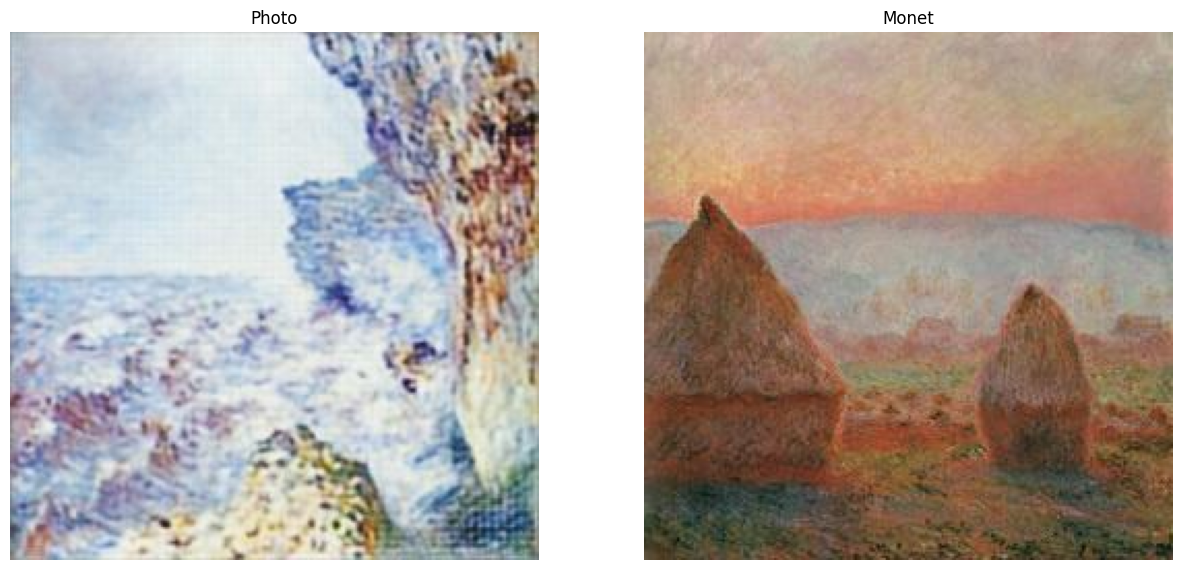

In [35]:
sample_photo2monet_path = "images/9b85a6c570.jpg"
sample_photo2monet = read_img(sample_photo2monet_path)

plt.figure(figsize=(15,10))

plt.subplot(121)
plt.title("Photo")
plt.imshow(sample_photo2monet)
plt.axis("off")

plt.subplot(122)
plt.title("Monet")
plt.imshow(sample_monet)
plt.axis("off")

______
# 4. Conclusions
______



Overall, CycleGAN performs well. The generated images exhibited convincing stylistic elements characteristic of Monet’s work, including the unique color palette and brushstroke techniques. This project demonstrates the potential of GANs to create high-quality, style-transferred images, bridging the gap between art and artificial intelligence.

However, the codes works well in my local working enviroment. When I uploaded the notebook in Kaggle, the runtime was more than 9 hours and interruped unexpectlly. Therefore, my Kaggle submission is not successful.

Future improvements could involve fine-tuning the model’s hyperparameters, experimenting with different network architectures, and incorporating a broader range of artistic styles. This exploration of GANs in the context of artistic style transfer highlights the exciting possibilities at the intersection of technology and creativity.